In [1]:
# importing data
import pandas as pd
import numpy as np
np.random_state = 42
data = pd.read_csv('D:/MSBA/10 Applied Machine Learning/assignment/1/sgemm_product_dataset/sgemm_product.csv')
print(data.head())

   MWG  NWG  KWG  MDIMC  NDIMC  MDIMA  NDIMB  KWI  VWM  VWN  STRM  STRN  SA  \
0   16   16   16      8      8      8      8    2    1    1     0     0   0   
1   16   16   16      8      8      8      8    2    1    1     0     0   0   
2   16   16   16      8      8      8      8    2    1    1     0     0   1   
3   16   16   16      8      8      8      8    2    1    1     0     0   1   
4   16   16   16      8      8      8      8    2    1    1     0     1   0   

   SB  Run1 (ms)  Run2 (ms)  Run3 (ms)  Run4 (ms)  
0   0     115.26     115.87     118.55     115.80  
1   1      78.13      78.25      79.25      79.19  
2   0      79.84      80.69      80.76      80.97  
3   1      84.32      89.90      86.75      85.58  
4   0     115.13     121.98     122.73     114.81  


In [2]:
# creating target variable (average of 4 runtime)
data['av_run'] = data[['Run1 (ms)','Run2 (ms)','Run3 (ms)','Run4 (ms)']].mean(axis = 1).round(2)
print(data[['Run1 (ms)', 'Run2 (ms)','Run3 (ms)', 'Run4 (ms)','av_run']].head())

   Run1 (ms)  Run2 (ms)  Run3 (ms)  Run4 (ms)  av_run
0     115.26     115.87     118.55     115.80  116.37
1      78.13      78.25      79.25      79.19   78.70
2      79.84      80.69      80.76      80.97   80.56
3      84.32      89.90      86.75      85.58   86.64
4     115.13     121.98     122.73     114.81  118.66


In [3]:
# dropping 4 obselete run columns
data.drop(columns=['Run1 (ms)', 'Run2 (ms)','Run3 (ms)', 'Run4 (ms)'], inplace = True)
data.columns

Index(['MWG', 'NWG', 'KWG', 'MDIMC', 'NDIMC', 'MDIMA', 'NDIMB', 'KWI', 'VWM',
       'VWN', 'STRM', 'STRN', 'SA', 'SB', 'av_run'],
      dtype='object')

In [4]:
# converting av_run into binary variable
import numpy as np
y_median = np.median(data['av_run'])
data['av_run_binary'] = [1 if i > y_median else 0 for i in data['av_run']]
print(data[['av_run','av_run_binary']].head())

   av_run  av_run_binary
0  116.37              1
1   78.70              1
2   80.56              1
3   86.64              1
4  118.66              1


In [5]:
# creating X and y varible from data
X = data.iloc[:,:-2]
y = data.iloc[:,-1]
print(X.shape)

(241600, 14)


# Task 1: running clustering algorithm in above dataset

In [6]:
# clustering dataset using k-means
import numpy as np
from sklearn.mixture import GaussianMixture

np.random.seed(42)

clust = GaussianMixture()

aic = []

for k in range(2,10):
    clust.set_params(n_components = k)
    clust.fit(X)
    aic.append(clust.aic(X))

print(aic)

[15851713.194510542, 14574301.007316358, 13664865.636716658, 12765371.338029355, 12889251.053440083, 11640380.80875997, 11000123.848363558, 11046740.815719668]


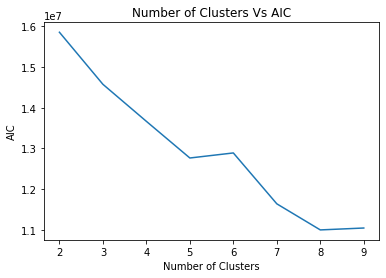

In [11]:
# plotting elbow curve between number of clusters and rmse
import matplotlib.pyplot as plt
def plot_line(x,y,title,ylabel,xlabel):
    plt.plot(x,y)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()
    
plot_line(range(2,10),aic,'Number of Clusters Vs AIC','AIC','Number of Clusters')

# Feature Selection Algorithm: Decision Tree

In [61]:
# feature selection through decision tree
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier()
dt_clf.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [62]:
import pandas as pd
feature_imp = pd.DataFrame({'name':X.columns, 'score':dt_clf.feature_importances_})
print(feature_imp.sort_values('score', ascending = False))

     name     score
0     MWG  0.270352
1     NWG  0.170793
4   NDIMC  0.151463
3   MDIMC  0.151380
12     SA  0.053769
10   STRM  0.043231
8     VWM  0.037922
13     SB  0.030403
9     VWN  0.026270
2     KWG  0.022784
6   NDIMB  0.011721
5   MDIMA  0.011331
11   STRN  0.009589
7     KWI  0.008992


In [14]:
# selecting top features based on above table
X_sub = X[['MWG','NWG','MDIMC','NDIMC']]
X_sub.shape

(241600, 4)

In [16]:
# making cluster with just above features
def clustering(X):
    dr_clust = GaussianMixture()
    aic = []
    for k in range(2,10):
        dr_clust.set_params(n_components = k)
        dr_clust.fit(X)
        aic.append(dr_clust.aic(X))
    return aic

dr_rmse = clustering(X_sub)
print(dr_rmse)

[6212012.647022227, 4961580.586297929, 4080880.0577838696, 3201288.501254404, 2790692.1272740597, 2112977.3416448315, 1551979.7368850834, 1083021.4572051824]


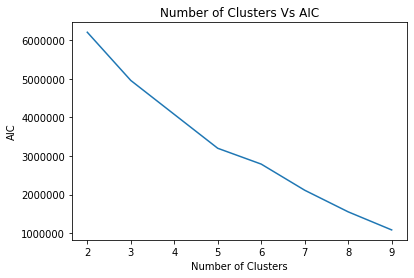

In [17]:
plot_line(range(2,10), dr_rmse,'Number of Clusters Vs AIC','AIC','Number of Clusters')

In [18]:
kmeans_comparision = pd.DataFrame({'Clusters':range(2,10),'Normal':aic,'DR_dt':dr_rmse})
print(kmeans_comparision)

   Clusters        Normal         DR_dt
0         2  1.585171e+07  6.212013e+06
1         3  1.457430e+07  4.961581e+06
2         4  1.366487e+07  4.080880e+06
3         5  1.276537e+07  3.201289e+06
4         6  1.288925e+07  2.790692e+06
5         7  1.164038e+07  2.112977e+06
6         8  1.100012e+07  1.551980e+06
7         9  1.104674e+07  1.083021e+06


In [19]:
# function for adding column to a dataframe
def add_column(df,col_name, col):
    df[col_name] = col

# Dimensionality Reduction - PCA

In [20]:
# using PCA for dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [21]:
print([round(x,2) for x in pca.explained_variance_ratio_])

array([4.53639997e-01, 4.52928645e-01, 2.52855826e-02, 2.10774165e-02,
       1.72858772e-02, 1.71234688e-02, 8.64408260e-03, 2.25738761e-03,
       7.53872687e-04, 7.52849140e-04, 6.27052115e-05, 6.27052115e-05,
       6.27052115e-05, 6.27052115e-05])

In [22]:
# as can be seen from above ratio top 2 companents explain 90% variance in data
pca = PCA(n_components = 2)
X_pca_transformed = pca.fit_transform(X)
pca.explained_variance_ratio_

array([0.45364   , 0.45292865])

In [23]:
# using transformed X_pca for clustering
pca_rmse = clustering(X_pca_transformed)
print(pca_rmse)

[4169555.9385316526, 3684762.59311448, 3342088.8298783167, 3043206.5440544873, 2919463.0383552304, 2692094.6986783496, 2460434.216434866, 2320636.0023745853]


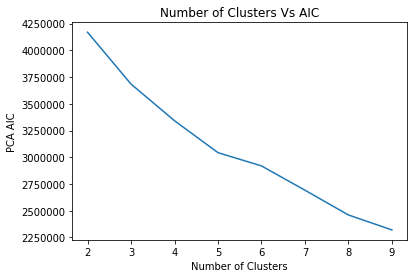

In [24]:
plot_line(range(2,10), pca_rmse,'Number of Clusters Vs AIC','PCA AIC','Number of Clusters')

In [25]:
# adding pca_rmse in DF with other RMSEs
add_column(kmeans_comparision,'pca_AIC', pca_rmse)
print(kmeans_comparision)

   Clusters        Normal         DR_dt       pca_AIC
0         2  1.585171e+07  6.212013e+06  4.169556e+06
1         3  1.457430e+07  4.961581e+06  3.684763e+06
2         4  1.366487e+07  4.080880e+06  3.342089e+06
3         5  1.276537e+07  3.201289e+06  3.043207e+06
4         6  1.288925e+07  2.790692e+06  2.919463e+06
5         7  1.164038e+07  2.112977e+06  2.692095e+06
6         8  1.100012e+07  1.551980e+06  2.460434e+06
7         9  1.104674e+07  1.083021e+06  2.320636e+06


# Dimensionality Reduction : ICA

In [7]:
# using ICA to find out important dimmensions from the dataset
from sklearn.decomposition import FastICA

ica = FastICA()
kmeans = GaussianMixture()

ica_n_comp = []
ica_n_clust = []
ica_aic = []

for n in range(2,14):
    ica.set_params(n_components = n)
    X_ica = ica.fit_transform(X)
    for k in range(2,10):
        kmeans.set_params(n_components = k)
        kmeans.fit(X_ica)
        ica_n_comp.append(n)
        ica_n_clust.append(k)
        ica_aic.append(kmeans.aic(X_ica))

In [8]:
ica_matrix = pd.DataFrame({'n_components':ica_n_comp, 'n_clusters':ica_n_clust, 'AIC':ica_aic})
print(ica_matrix.sort_values('AIC'))

    n_components  n_clusters           AIC
94            13           8 -3.072039e+07
95            13           9 -3.070181e+07
93            13           7 -3.067973e+07
92            13           6 -3.051625e+07
91            13           5 -3.049119e+07
..           ...         ...           ...
5              2           7 -4.796070e+06
6              2           8 -4.795872e+06
7              2           9 -4.795837e+06
1              2           3 -4.739595e+06
0              2           2 -4.701978e+06

[96 rows x 3 columns]


In [9]:
print(ica_matrix[ica_matrix['n_clusters']==3])

    n_components  n_clusters           AIC
1              2           3 -4.739595e+06
9              3           3 -7.005897e+06
17             4           3 -9.315132e+06
25             5           3 -1.167135e+07
33             6           3 -1.399542e+07
41             7           3 -1.634293e+07
49             8           3 -1.859609e+07
57             9           3 -2.102571e+07
65            10           3 -2.337034e+07
73            11           3 -2.563005e+07
81            12           3 -2.792143e+07
89            13           3 -3.013889e+07


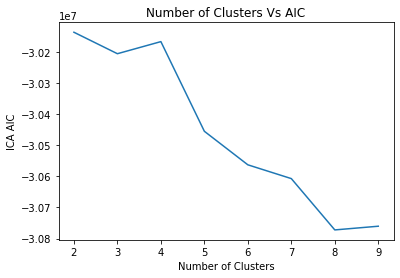

In [56]:
plot_line(range(2,10), ica_matrix[ica_matrix['n_components']==13]['AIC'],'Number of Clusters Vs AIC','ICA AIC','Number of Clusters')

In [46]:
ica_matrix[ica_matrix['n_components']==13]['AIC']

88   -3.016418e+07
89   -3.023220e+07
90   -3.048234e+07
91   -3.047334e+07
92   -3.055860e+07
93   -3.066914e+07
94   -3.068144e+07
95   -3.077590e+07
Name: AIC, dtype: float64

In [47]:
# adding ica rmse in DF with other RMSEs
kmeans_comparision['ica_AIC'] = ica_matrix[ica_matrix['n_components']==13]['AIC'] 
print(kmeans_comparision)

   Clusters        Normal         DR_dt       pca_AIC  ica_AIC
0         2  1.585171e+07  6.212013e+06  4.169556e+06      NaN
1         3  1.457430e+07  4.961581e+06  3.684763e+06      NaN
2         4  1.366487e+07  4.080880e+06  3.342089e+06      NaN
3         5  1.276537e+07  3.201289e+06  3.043207e+06      NaN
4         6  1.288925e+07  2.790692e+06  2.919463e+06      NaN
5         7  1.164038e+07  2.112977e+06  2.692095e+06      NaN
6         8  1.100012e+07  1.551980e+06  2.460434e+06      NaN
7         9  1.104674e+07  1.083021e+06  2.320636e+06      NaN


# Dimenssionality Reduction: Randomized Projection

In [10]:
# using gaussian random projection to reduce dimmension of dataset and testing with k-means to find optinal n_components
from sklearn.random_projection import GaussianRandomProjection

transformer = GaussianRandomProjection()
kmeans = GaussianMixture()

n_comp = []
n_clust = []
grp_aic = []

for n in range(2,14):
    transformer.set_params(n_components = n)
    X_grp = transformer.fit_transform(X)
    for k in range(2,10):
        kmeans.set_params(n_components = k)
        kmeans.fit(X_grp)
        n_comp.append(n)
        n_clust.append(k)
        grp_aic.append(kmeans.aic(X_grp))

In [11]:
grp_matrix = pd.DataFrame({'n_components':n_comp, 'n_clusters':n_clust, 'AIC':grp_aic})

In [12]:
print(grp_matrix.sort_values('AIC'))

    n_components  n_clusters           AIC
7              2           9  4.420548e+06
6              2           8  4.422058e+06
3              2           5  4.423922e+06
5              2           7  4.425806e+06
4              2           6  4.426441e+06
..           ...         ...           ...
81            12           3  1.368309e+07
65            10           3  1.384181e+07
88            13           2  1.388169e+07
80            12           2  1.419101e+07
64            10           2  1.432050e+07

[96 rows x 3 columns]


In [13]:
# from above matrix it can be seen rmse is minimum for n_components = 2
print(grp_matrix[grp_matrix['n_clusters'] == 4])

    n_components  n_clusters           AIC
2              2           4  4.434280e+06
10             3           4  6.260392e+06
18             4           4  7.454681e+06
26             5           4  9.382262e+06
34             6           4  9.709010e+06
42             7           4  1.102211e+07
50             8           4  1.188682e+07
58             9           4  1.267842e+07
66            10           4  1.341028e+07
74            11           4  1.255386e+07
82            12           4  1.320385e+07
90            13           4  1.277611e+07


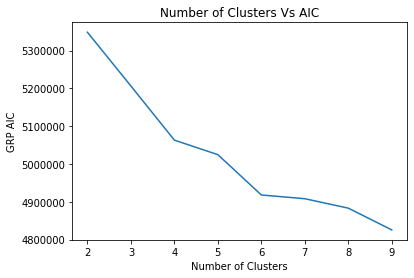

In [52]:
plot_line(range(2,10), grp_matrix[grp_matrix['n_components'] == 2]['AIC'],'Number of Clusters Vs AIC','GRP AIC','Number of Clusters')

In [57]:
# adding GRP rmse in DF with other RMSEs
add_column(kmeans_comparision,'grp_rmse', grp_matrix[grp_matrix['n_components'] == 2]['AIC'])
print(kmeans_comparision)

   Clusters        Normal         DR_dt       pca_AIC  ica_AIC      grp_rmse
0         2  1.585171e+07  6.212013e+06  4.169556e+06      NaN  5.348678e+06
1         3  1.457430e+07  4.961581e+06  3.684763e+06      NaN  5.206392e+06
2         4  1.366487e+07  4.080880e+06  3.342089e+06      NaN  5.063137e+06
3         5  1.276537e+07  3.201289e+06  3.043207e+06      NaN  5.024640e+06
4         6  1.288925e+07  2.790692e+06  2.919463e+06      NaN  4.917949e+06
5         7  1.164038e+07  2.112977e+06  2.692095e+06      NaN  4.908052e+06
6         8  1.100012e+07  1.551980e+06  2.460434e+06      NaN  4.883094e+06
7         9  1.104674e+07  1.083021e+06  2.320636e+06      NaN  4.825461e+06


# Task 4: Training Neural Network

In [58]:
# creating a neural network running function
from sklearn.neural_network import MLPClassifier

def run_nn(X_train, X_test, y_train,y_test):
    nn_clf = MLPClassifier()
    nn_clf.fit(X_train,y_train)
    training_accuracy = nn_clf.score(X_train,y_train)
    test_accuracy = nn_clf.score(X_test,y_test)
    return(training_accuracy,test_accuracy)
    

In [59]:
# training and testing accuracy for normal data (w/o any dimensionality reduction)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train,y_test = train_test_split(X,y,test_size = 0.3)

print(X.shape, X_train.shape, X_test.shape)

(241600, 14) (169120, 14) (72480, 14)


In [60]:
print(run_nn(X_train, X_test, y_train,y_test))

(0.9792100283822138, 0.9782146799116997)


In [61]:
# training and testing data set for feature selected through decision tree 
X_train_dt = X_train[['MWG','NWG','MDIMC','NDIMC']]
X_test_dt = X_test[['MWG','NWG','MDIMC','NDIMC']]
print(X_train_dt.shape, X_test_dt.shape)

(169120, 4) (72480, 4)


In [62]:
# training and testing data for feature selected through PCA
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train_pca.shape, X_test_pca.shape)

(169120, 2) (72480, 2)


In [63]:
# training and testing data for feature transformed through ICA
ica.set_params(n_components = 3)
X_train_ica = ica.fit_transform(X_train)
X_test_ica = ica.transform(X_test)

In [64]:
# traing and testing data for feature transformed through GRP
transformer.set_params(n_components = 4)
X_train_grp = transformer.fit_transform(X_train)
X_testr_grp = transformer.transform(X_test)

In [65]:
# running above different training and testing dataset through NN
X_train_lst = [X_train,X_train_dt, X_train_pca, X_train_ica, X_train_grp]
X_test_lst = [X_test, X_test_dt, X_test_pca, X_test_ica, X_testr_grp]

train_accu = []
test_accu = []

for i in range(5):
    nn_accu = run_nn(X_train_lst[i],X_test_lst[i],y_train,y_test)
    train_accu.append(nn_accu[0])
    test_accu.append(nn_accu[1])

In [66]:
# result comparision for transformed data
methodology = ['No Transformation','Fearure Selection: Decision Tree', 'PCA','ICA','RP - Gaussian Randmized Projections']

nn_results_comparision = pd.DataFrame({'Method': methodology,'Train Accuracy':train_accu, 'Test Accuracy':test_accu})
print(nn_results_comparision)

                                Method  Train Accuracy  Test Accuracy
0                    No Transformation        0.980954       0.979539
1     Fearure Selection: Decision Tree        0.885732       0.884975
2                                  PCA        0.739776       0.742619
3                                  ICA        0.751236       0.754098
4  RP - Gaussian Randmized Projections        0.837737       0.839087


# Task 5: applying neural network on clustering outcome

In [67]:
clust.set_params(n_components = 5)
y_predict = clust.fit_predict(X)
print(y_predict[:5])

[4 4 4 4 4]


In [68]:
#running NN on clustering output

X_train, X_test, y_train,y_test = train_test_split(y_predict,y,test_size = 0.3)

print(run_nn(X_train.reshape(-1,1),X_test.reshape(-1,1),y_train,y_test))

(0.6979600283822138, 0.6995998896247241)
